# Combining two Gaussians

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import importance_sampler as isamp
import scipy.stats
import corner, emcee
%matplotlib inline

In [2]:
plt.rc("font", size=18, family="serif")
plt.rc("text", usetex=True)

In [3]:
means = np.array([3.0, -0.0])
stddevs = np.array([1.0, 0.1]) #standard deviations
rho = -0.99 #correlation
cov = np.array([[stddevs[0]**2, rho*stddevs[0]*stddevs[1]],
                [rho*stddevs[0]*stddevs[1], stddevs[1]]])
#cov = np.array([[1,0.1],[0.1,0.5]])
icov = np.linalg.inv(cov)

In [4]:
N_samples = 100000
chain = np.random.multivariate_normal(mean=means, cov=cov, size=N_samples)
lnlikes = np.log(scipy.stats.multivariate_normal.pdf(chain, mean=means, cov=cov))

In [5]:
IS = isamp.ImportanceSampler(chain, lnlikes, scale=8)
IS.select_training_points(200, method="LH")
IS.train()

Text(0,0.5,'$y$')

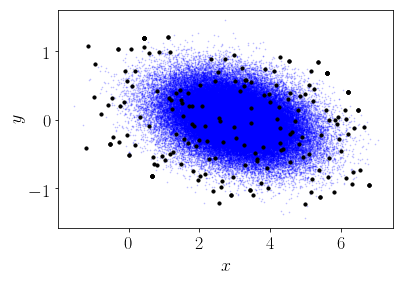

In [6]:
plt.scatter(chain[:,0], chain[:,1], c='b', s=0.5, alpha=0.2)
points,_ = IS.get_training_data()
plt.scatter(points[:,0], points[:,1], c='k', s=10)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")

## Testing the importance sampler object

The only way to truly test if the new sampler works is to use it in an MCMC chain and see if we recover the same posteriors as the original.

In [7]:
def log_likelihood(params):
    return IS.predict(np.atleast_2d(params))

initial = means
ndim, nwalkers = len(initial), 16
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood)
print("Running first burn-in")
p0 = initial + 1e-4*np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 2000)
print("Running second burn-in")
p0 = p0[np.argmax(lp)] + 1e-4*np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 2000)
sampler.reset()
print("Running production...")
sampler.run_mcmc(p0, 2000);

Running first burn-in
Running second burn-in
Running production...


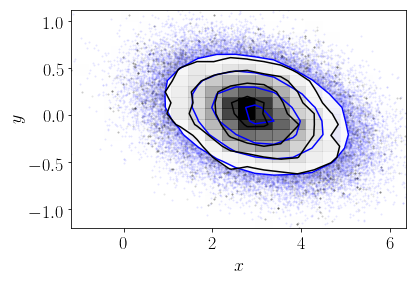

In [8]:
testchain = sampler.flatchain
corner.hist2d(chain[:,0], chain[:,1], color='b', plot_datapoints=1)
corner.hist2d(testchain[:,0], testchain[:,1], color='black', plot_datapoints=1)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.savefig("example_mcmc.png", dpi=300, bbox_inches="tight")

In [9]:
means2 = np.array([4.5, 0.0])
stddevs2 = np.array([0.2, 0.1]) #standard deviations
rho2 = 0.9 #correlation
cov2 = np.array([[stddevs2[0]**2, rho2*stddevs2[0]*stddevs2[1]],
                [rho2*stddevs2[0]*stddevs2[1], stddevs2[1]]])
#cov2 = np.array([[1,0.1],[0.1,0.5]])
icov2 = np.linalg.inv(cov2)

In [10]:
chain2 = np.random.multivariate_normal(mean=means2, cov=cov2, size=N_samples)
lnlikes2 = np.log(scipy.stats.multivariate_normal.pdf(chain2, mean=means2, cov=cov2))

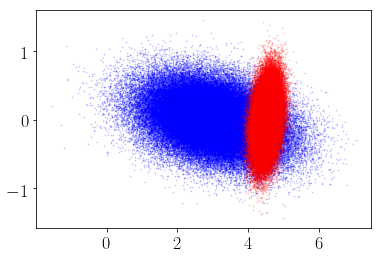

In [11]:
plt.scatter(chain[:,0], chain[:,1], c='b', s=0.5, alpha=0.2)
plt.scatter(chain2[:,0], chain2[:,1], c='r', s=0.5, alpha=0.2)

In [12]:
IS2 = isamp.ImportanceSampler(chain2, lnlikes2, scale=8)
IS2.select_training_points(200, method="LH")
IS2.train()

In [13]:
def log_likelihood_combined(params):
    return IS.predict(np.atleast_2d(params)) + IS2.predict(np.atleast_2d(params))

initial = means
ndim, nwalkers = len(initial), 16
sampler2 = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood_combined)
print("Running first burn-in")
p0 = initial + 1e-4*np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler2.run_mcmc(p0, 2000)
print("Running second burn-in")
p0 = p0[np.argmax(lp)] + 1e-4*np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler2.run_mcmc(p0, 2000)
sampler2.reset()
print("Running production...")
sampler2.run_mcmc(p0, 2000);

Running first burn-in
Running second burn-in
Running production...


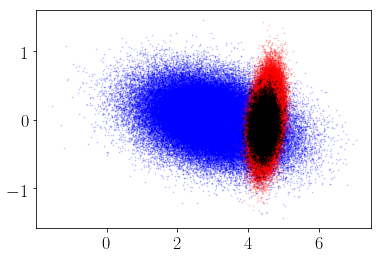

In [14]:
testchain = sampler2.flatchain
plt.scatter(chain[:,0], chain[:,1], c='b', s=0.5, alpha=0.2)
plt.scatter(chain2[:,0], chain2[:,1], c='r', s=0.5, alpha=0.2)
plt.scatter(testchain[:,0], testchain[:,1], c='k', s=0.5, alpha=0.2)